# Discovering structure in heatmap data

***

## Commands used to download the data

```bash
#!/usr/bin/env bash
# This script downloads the CAMI data, just pipe it the samples you want (Airways, Oral etc.)

dataset=$1
mkdir $1 && cd $_
echo "downloading the ${1} read data from CAMI"
URL="https://openstack.cebitec.uni-bielefeld.de:8080/swift/v1/CAMI_${1}/"
echo "url: ${URL}"

# get the file list
curl ${URL} | grep 'fq.gz' >> reads.list

# download each file in turn and store in sequentially labelled fastqs
COUNTER=1
while read -r line
    do
    download=${URL}${line}
    curl ${download} -o ${COUNTER}.fastq.gz
    COUNTER=$((COUNTER + 1))
    echo "downloaded ${download} and saved to ${COUNTER}.fastq.gz"
    done < reads.list
echo "finished."
```

## Commands used to generate the sketches

``` bash
#!/usr/bin/env bash

# This script automates the submission of HULK jobs to the Scafell cluster.
# It will run HULK on each set of CAMI samples, storing the sketches for each in a separate directory

# PARAMETERS
## general
CPU=12
QUEUE=scafellpikeSKL
WALL=0:20
SAMPLES=( "Airways" "Gastrointestinal_tract" "Oral" "Skin" "Urogenital_tract" )
## hulk
K=21
S=512

# JOB SUBMISSION
mkdir illumina-hulk-sketches-k${K}-s${S} && cd $_
counter=0
## the cami files are sequentially ordered in each download (1-10 = pacbio, 11-20 = short read)
for i in {11..20}
  do
  for name in "${SAMPLES[@]}"
    do
    outfile=${name}.${i}
    CMD="gunzip -c ../${name}/${i}.fastq.gz | hulk sketch -p ${CPU} -s ${S} -k ${K} -o ${outfile}"
    echo $CMD | bsub -n ${CPU} -R "span[ptile=${CPU}]" -W ${WALL} -q ${QUEUE}
  done
done
```

## Command used to generate pairwise jaccard similarity matrix from the sketches


```
# This will leave us with a file called `sketches-sr-k21-s512.jsMatrix.csv` which we then use in this analysis.
hulk smash -o sketches-sr-k7-s256 --jsMatrix
```

In [3]:
# Pandas for managing datasets
import pandas as pd

# Re for cleaning up data headers
import re

# Matplotlib for additional customization
from matplotlib import pyplot as plt
%matplotlib inline

# Seaborn for plotting and styling
import seaborn as sns
sns.set()

/Users/willrowe/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/willrowe/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [4]:
# Read dataset
df = pd.read_csv('data/k21s512.js-matrix.csv')

In [5]:
# Rename columns to just body site
df = df.rename(columns=lambda x: re.sub('.\d+.sketch','',x))
df.head()

,Urogenital_tract,Gastrointestinal_tract,Oral,Oral,Skin,Skin,Airways,Gastrointestinal_tract,Gastrointestinal_tract,Gastrointestinal_tract,...,Skin,Urogenital_tract,Airways,Airways,Gastrointestinal_tract,Skin,Urogenital_tract,Gastrointestinal_tract,Oral,Skin
0,1.00,0.87,0.87,0.88,0.89,0.85,0.86,0.86,0.87,0.87,...,0.80,0.84,0.88,0.86,0.86,0.84,0.86,0.85,0.85,0.86
1,0.87,1.00,0.86,0.88,0.89,0.86,0.87,0.91,0.91,0.93,...,0.80,0.82,0.89,0.87,0.90,0.87,0.86,0.90,0.86,0.86
2,0.87,0.86,1.00,0.89,0.88,0.86,0.85,0.84,0.86,0.88,...,0.81,0.84,0.88,0.85,0.86,0.84,0.81,0.84,0.90,0.85
3,0.88,0.88,0.89,1.00,0.89,0.87,0.86,0.86,0.87,0.89,...,0.82,0.84,0.88,0.86,0.87,0.85,0.83,0.85,0.89,0.86
4,0.89,0.89,0.88,0.89,1.00,0.89,0.90,0.85,0.89,0.88,...,0.85,0.85,0.90,0.91,0.87,0.89,0.84,0.86,0.87,0.88


In [6]:
# Check number of samples for each body site
df.columns.value_counts()

Gastrointestinal_tract    10
Skin                      10
Oral                       9
Urogenital_tract           8
Airways                    7
dtype: int64

In [7]:
# Get the body site labels
sites = pd.Series(df.columns)

In [8]:
# Create a palette to identify the body sites
sites_pal = sns.color_palette("husl", len(sites.unique()))

In [9]:
# Create a lookup table to link palette to body site
lut = dict(zip(sites.unique(), sites_pal))

In [10]:
# Convert the palette to vectors that will be drawn on the side of the matrix
colours = sites.map(lut)

Text(0.5,0.98,'heatmap...')

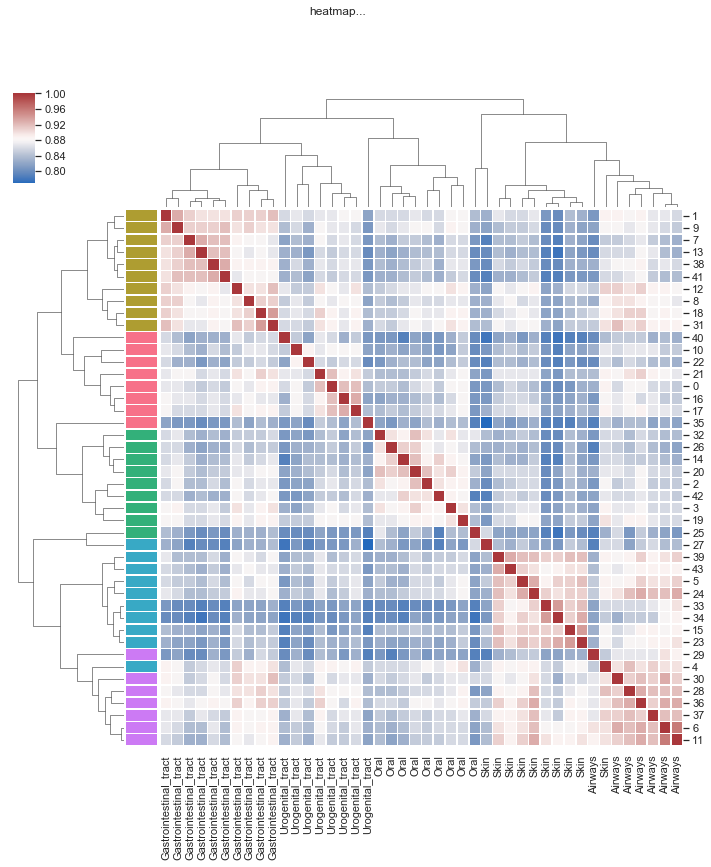

In [11]:
g = sns.clustermap(df, method='complete', metric='correlation', cmap="vlag",
                   row_colors=colours, row_cluster=True, col_cluster=True,
                   linewidths=.50, figsize=(12, 12))
g.fig.suptitle("heatmap...")